## HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2023`__

> Updated: 06/30/2023

Last homework for 261!!!

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP. In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia. You will likely want to select 16 or 32 cores when you set up your cluster, as graph processing with Spark can take some time. If you are working on free trial credits, then you maximum will be 16 cores. You'll also need to enable GraphFrames when you spin up your cluster or you won't be able to complete the last question.

By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [14]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

### Start Spark and the Spark UI

In [15]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import os

try:
    spark
except NameError:
    print('starting Spark')
    app_name = 'HW5_notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

ZONE = os.getenv("ZONE") #new as of June 17, 2022 4:45PM PST; restart cluster to see thus env variable
spark_UI_info = f'''
To start the SPARK UI

Copy the following command  to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .
Run the following command to establish the SSH Tunnel:

gcloud compute ssh w261-m --zone {ZONE} --ssh-flag "-L 8080:localhost:4040" '''

print(spark_UI_info)


To start the SPARK UI

Copy the following command  to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .
Run the following command to establish the SSH Tunnel:

gcloud compute ssh w261-m --zone us-west1-a --ssh-flag "-L 8080:localhost:4040" 


<img src='https://www.dropbox.com/s/tlb4uiakj2bx7qg/Three_steps_launch_SparkUI.png?raw=true' style='width:100%'>

## Set up global variables for cloud buckets (both Data, Staging) and for Zone 

In [16]:
import os
from google.cloud import storage
DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1] # our private storage bucket location
HW5_FOLDER = f"{DATA_BUCKET}/notebooks/jupyter/Assignments/HW5"
print(f"Personal Data bucket:  {DATA_BUCKET}")
!gsutil ls -lh  {HW5_FOLDER} 

Personal Data bucket:  gs://w261-hr
      34 B  2023-07-22T20:51:32Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/HW5.md
 72.13 KiB  2023-07-22T20:59:11Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/ORIGINAL_hw5_workbook.ipynb
     631 B  2023-07-22T20:51:32Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/README.md
  1.33 MiB  2023-07-26T06:13:42Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/hw5_workbook-HR.ipynb
                                 gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/
TOTAL: 4 objects, 1472963 bytes (1.4 MiB)


In [17]:
sc = spark.sparkContext
spark

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) Multiple Choice:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Don't think in terms of any specific algorithm. Think in terms of the nature of the graph data structure itself).*

* __b) Multiple Choice:__ What specific design component in Dijkstra's algorithm makes this approach hard to parallelize?

* __c) Short Response:__ How does parallel breadth-first-search get around the problem that you identified in part `b`? At what expense? Your response should be 2-4 sentences. 

### Q1 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ 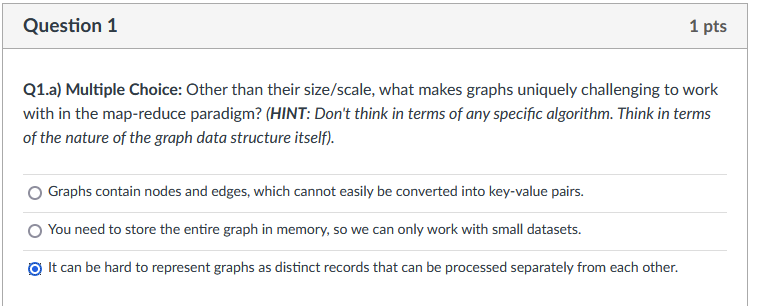

> __b)__ 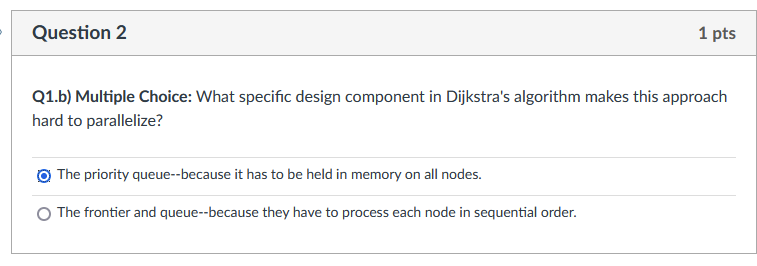

> __c)__ Parallel breadth-first-search gets around the parallelization problem by iterating through the dataset over and over again but parallelizing those iterations. The key-value pairs in these iterations are connections between nodes which are then reduced. This is done at the expense of a much more computationally intensive operation, essentially brute forcing the solution.
Parallel breadth-first-search gets around the parallelization problem by iterating through the dataset over and over again but parallelizing those iterations. The key-value pairs in these iterations are connections between nodes which are then reduced. This is done at the expense of a much more computationally intensive operation, essentially brute forcing the solution.

# ✅ Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) Multiple Dropdown:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph. 

* __b) Multiple Dropdown:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) Code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) Code:__ Fill in the missing code to complete the function `get_adj_list()`.

* __e) Multiple Choice:__ Which is the correct edge list for node `B`?

### Q2 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ 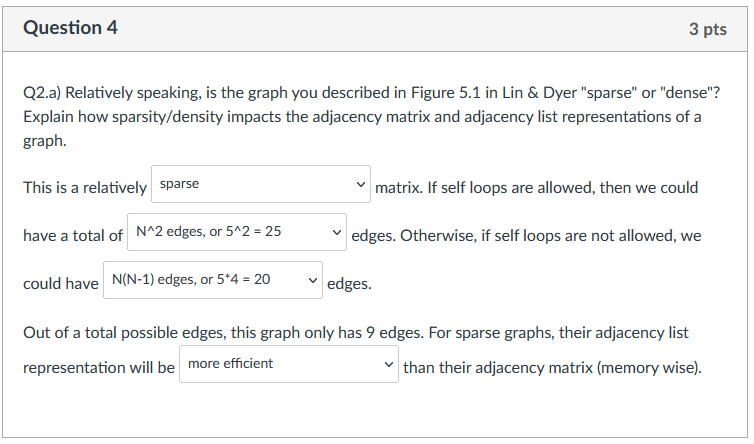

> __b)__ 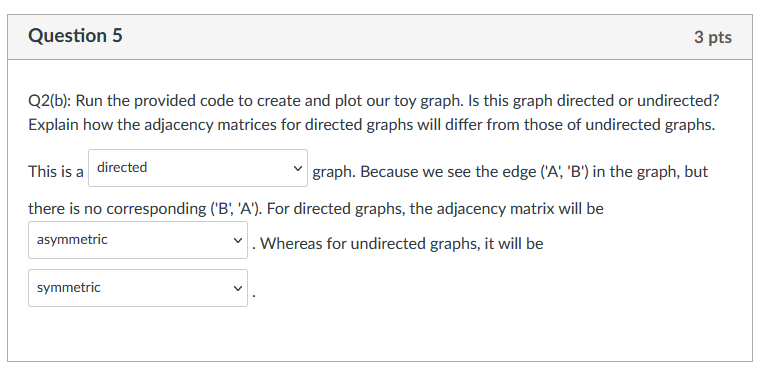

> __e)__ 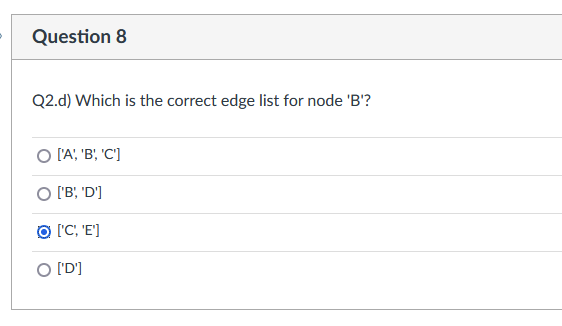

In [18]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

None

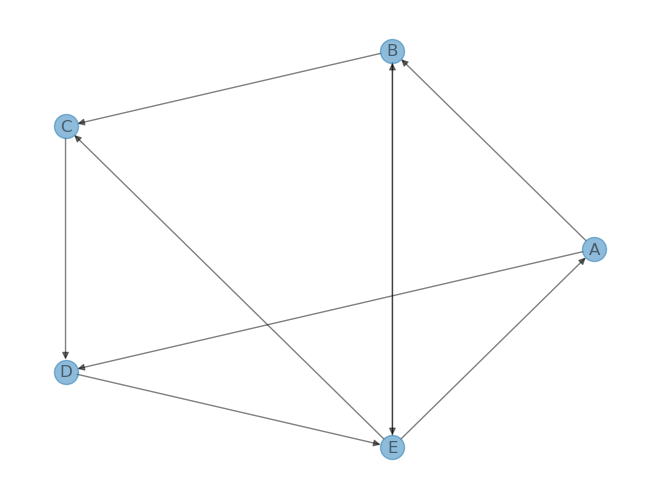

In [19]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [20]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for e in graph['edges']:
        i,j = e
        #print(i, j)
        adj_matr[j][i] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [21]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [22]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for e in graph['edges']:
        i,j = e
        adj_list[i].append(j)
    ############### (END) YOUR CODE #################
    return adj_list

In [23]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# ✅ Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

General note: Q3 and Q4 use a sped-up convergence method for the `power_iteration()` function. You should speed up convergence by multiplying by the tMatrix twice. `tMatrix = tMatrix.dot(tMatrix)`. So instead of:
```
Step 0: xInit * tMatrix
Step 1: xInit * tMatrix^2
Step 2: xInit * tMatrix^3
Step 3: xInit * tMatrix^4
...
```
you should instead consider
```
Step 0: xInit * tMatrix
Step 1: xInit * tMatrix^2
Step 2: xInit * tMatrix^4
Step 3: xInit * tMatrix^8
...
```
This may vary slightly from what you see in Demo 10


### Q3 Tasks:

* __a) Multiple Choice:__ It is common to explain PageRank using the analogy of a web surfer who visits a page, randomly clicks a link on that page, and repeats ad infinitum. In the context of this hypothetical infinite random walk across web pages on the internet, which of the following choices most clearly describes the event that the __teleportation__ represents?

* __b) Multiple Dropdowns:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) Multiple Dropdowns:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph, what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) Multiple Choice:__ What is a "right stochastic matrix"?

* __e) Code + Numerical Answer:__ Fill in the code below to compute the transition matrix for the toy graph from question 2. What is the value in the middle column of the last row (the probability of transitioning from node `E` to `C`)? Include the leading digit in front of the decimal, and round the number to at least 4 decimal places. Examples: 1.0000 or 0.1234. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __f) Code:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.
    * __`NOTE 3:`__ _refer to the General note section above, and use the `tMatrix = tMatrix.dot(tMatrix)` approach for faster convergence_.


* __g) Numerical Answer:__ How many iterations does it take to converge?

* __h) Multiple Choice:__ Which node is the least 'central' (i.e., it has the lowest ranked)?


### Q3 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ 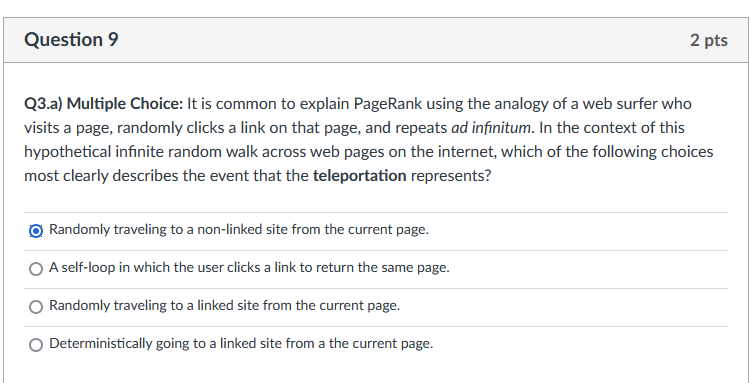

> __b)__ 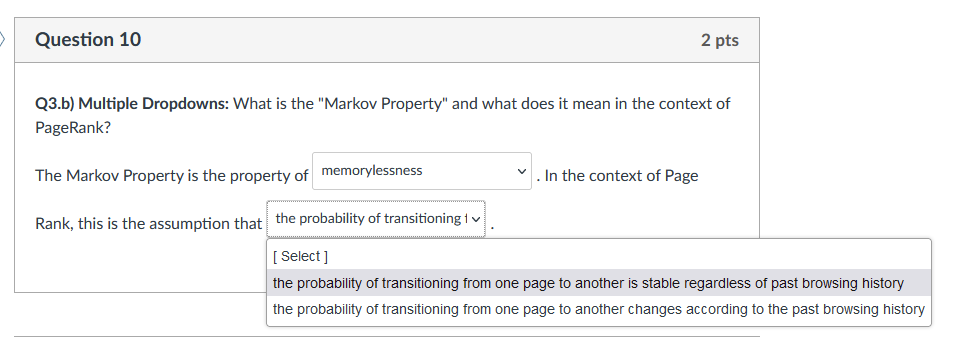

> __c)__ 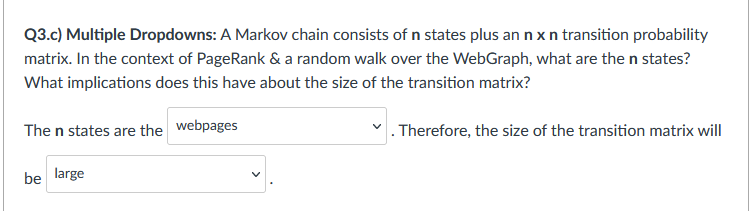

> __d)__ 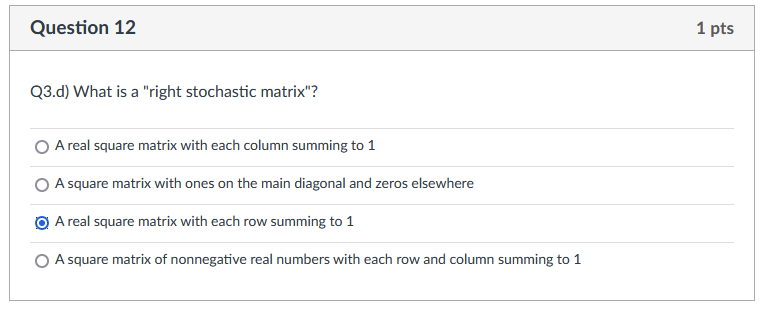

> __e)__ 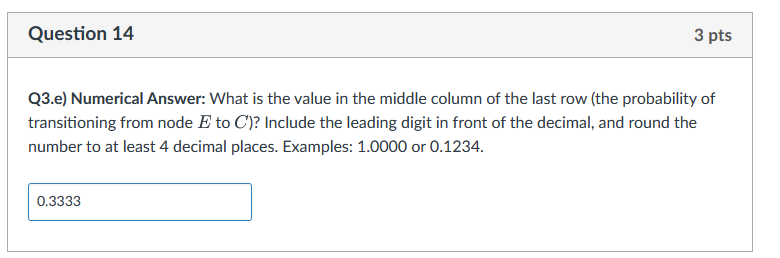

> __g)__ 6

> __h)__ A

In [24]:
# part e - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [25]:
# part e - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = np.array(TOY_ADJ_MATR)/np.array(TOY_ADJ_MATR).sum(axis=1, keepdims=True)

################ (END) YOUR CODE #################
print(transition_matrix)

[[0.         0.5        0.         0.5        0.        ]
 [0.         0.         0.5        0.         0.5       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333 0.         0.        ]]


In [11]:
# part f - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    for i in range(nIter):
        xInit = np.dot(xInit, tMatrix)
        tMatrix = tMatrix.dot(tMatrix)
        if verbose:
            print(f"Step {i+1}:", '\n', tMatrix, '\n\n', xInit, '\n')
            print(np.sum(xInit))
    state_vector = xInit
    
    ################ (END) YOUR CODE #################
    return state_vector

In [26]:
# part f - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Step 1: 
 [[0.         0.         0.25       0.         0.75      ]
 [0.16666667 0.16666667 0.16666667 0.5        0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.         0.16666667 0.16666667 0.5        0.16666667]] 

 [0.  0.5 0.  0.5 0. ] 

1.0
Step 2: 
 [[0.         0.125      0.125      0.375      0.375     ]
 [0.19444444 0.19444444 0.23611111 0.08333333 0.29166667]
 [0.         0.16666667 0.16666667 0.5        0.16666667]
 [0.05555556 0.05555556 0.13888889 0.16666667 0.58333333]
 [0.19444444 0.22222222 0.22222222 0.16666667 0.19444444]] 

 [0.25 0.25 0.25 0.25 0.  ] 

1.0
Step 3: 
 [[0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
 [0.09915123 0.17091049 0.18595679 0.26967593 0.27430556]
 [0.09259259 0.125      0.17361111 0.20833333 0.40046296]
 [0.13348765 0.17978395 0.19598765 0.21990741 0.27083333]
 [0.09027778 0.1570216  0.18016975 0.26273148 0.30979938]] 

 [0.0625     0.13541667 0.16

__`Expected Output for part e after 10 iterations:`__  
>Steady State Probabilities:
```
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947] 
```

# ✅ Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + Multiple Choice:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What are the first values in steps 1, 2, and 3 of the power iteration method? [__`HINT:`__ _We start the iteration at step number 0. If you start your iteration at step number 1, then you should answer with the values from step 2, 3, and 4 instead_]

* __b) Multiple Choice:__ What is wrong with what you see in part a? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __c) Multiple Choice:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __d) Multiple Choice:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Choose your reasoning.

* __e) Multiple Choice:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Choose your reasoning.

* __f) Multiple Choice:__ What modifications to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? [__`HINT:`__ _select 2 answers_]

### Q4 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

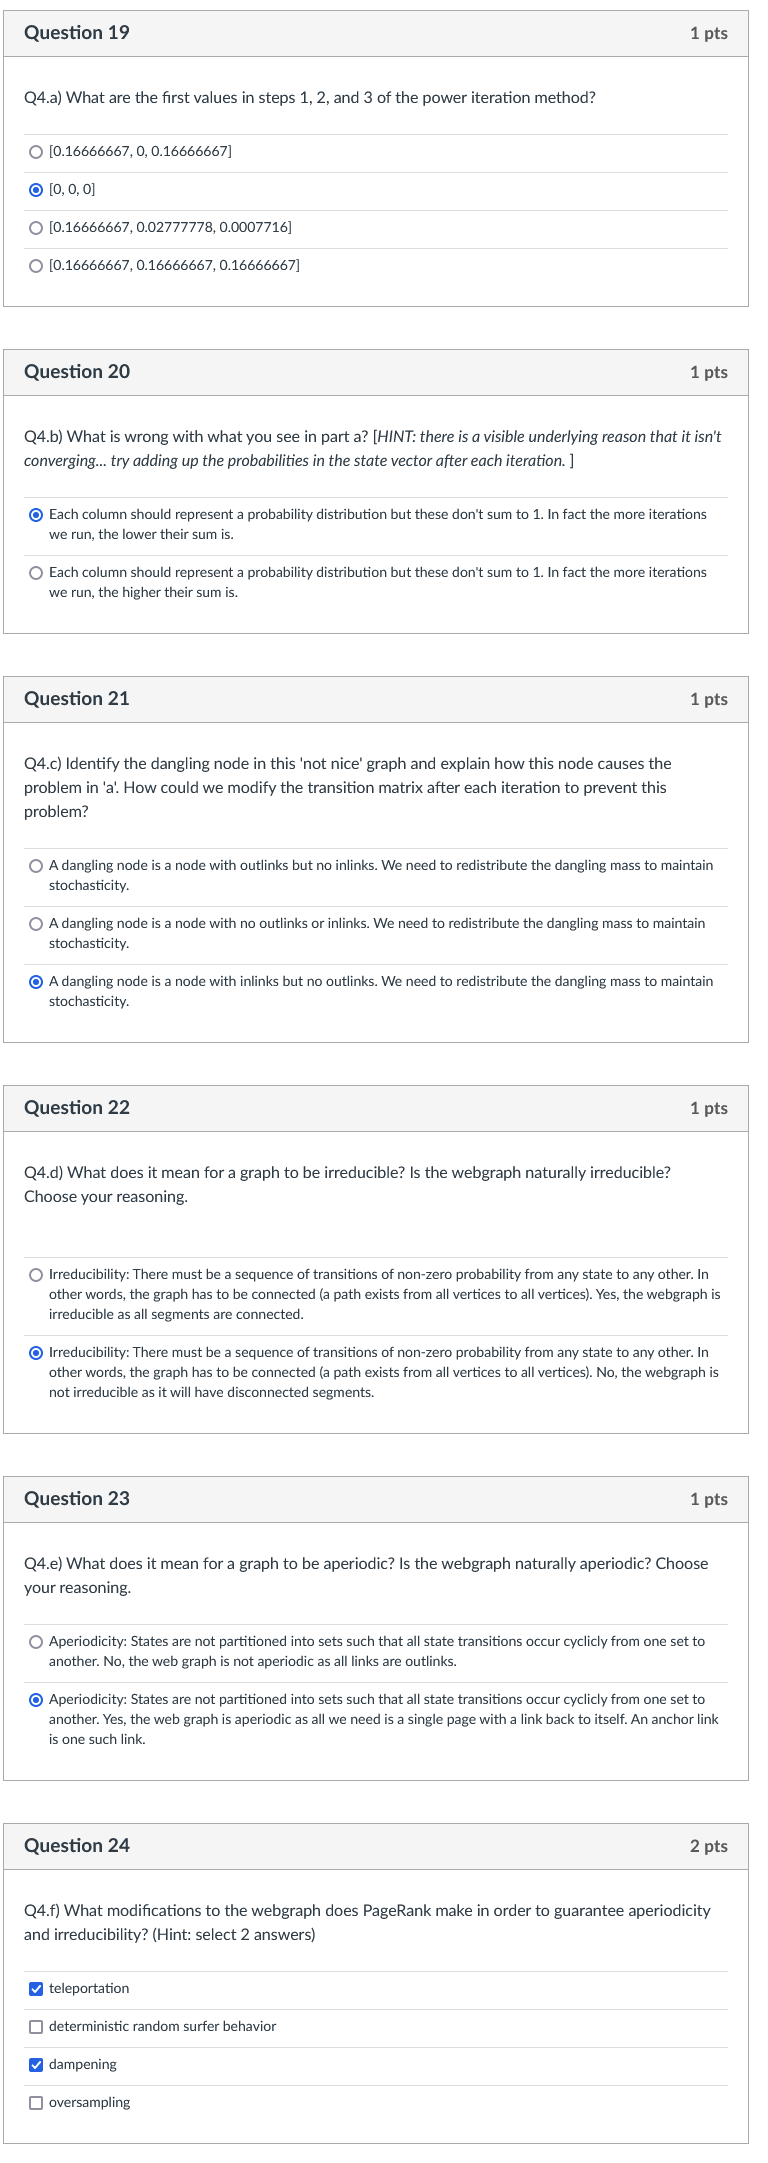

In [9]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

None

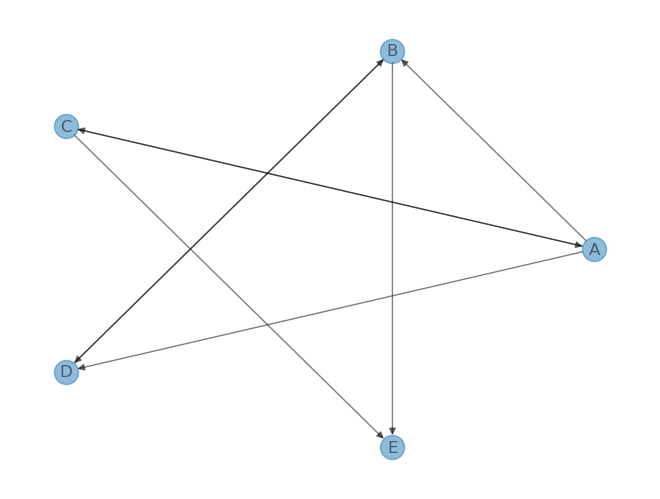

In [73]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [27]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
adj_matr = get_adj_matr(TOY2_GRAPH) # replace with your code

def get_trans_matr(adj_matr):
    mat = np.array(adj_matr, dtype=float)
    rowSums = mat.sum(axis=1, keepdims=True)
    return np.divide(mat, rowSums, out=np.zeros_like(mat), where=rowSums != 0)
    
trans_matr = get_trans_matr(adj_matr)

state = power_iteration(xInit, trans_matr, 10, verbose = True) # replace with your code
################ (END) YOUR CODE #################

Step 1: 
 [[0.16666667 0.33333333 0.         0.16666667 0.33333333]
 [0.         0.5        0.         0.         0.        ]
 [0.         0.16666667 0.16666667 0.16666667 0.        ]
 [0.         0.         0.         0.5        0.5       ]
 [0.         0.         0.         0.         0.        ]] 

 [0.         0.33333333 0.33333333 0.33333333 0.        ] 

1.0
Step 2: 
 [[0.02777778 0.22222222 0.         0.11111111 0.13888889]
 [0.         0.25       0.         0.         0.        ]
 [0.         0.11111111 0.02777778 0.11111111 0.08333333]
 [0.         0.         0.         0.25       0.25      ]
 [0.         0.         0.         0.         0.        ]] 

 [0.         0.22222222 0.05555556 0.22222222 0.16666667] 

0.6666666666666666
Step 3: 
 [[0.0007716  0.0617284  0.         0.0308642  0.0316358 ]
 [0.         0.0625     0.         0.         0.        ]
 [0.         0.0308642  0.0007716  0.0308642  0.03009259]
 [0.         0.         0.         0.0625     0.0625    ]
 [0.     

# ✅ Question 5: EDA part 1 (number of nodes)

## About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [5]:
HW5_FOLDER

'gs://w261-hr/notebooks/jupyter/Assignments/HW5'

In [6]:
!gsutil ls -l {HW5_FOLDER}

        34  2023-07-22T20:51:32Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/HW5.md
     73859  2023-07-22T20:59:11Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/ORIGINAL_hw5_workbook.ipynb
       631  2023-07-22T20:51:32Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/README.md
   1048479  2023-07-23T00:02:49Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/hw5_workbook-HR.ipynb
                                 gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/
TOTAL: 4 objects, 1123003 bytes (1.07 MiB)


In [104]:
!gsutil ls -l {HW5_FOLDER}/data

       167  2023-07-22T20:51:34Z  gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/test_graph.txt
                                 gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/all-pages-indexed-in/
                                 gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/all-pages-indexed-out/
                                 gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/indices/
TOTAL: 1 objects, 167 bytes (167 B)


In [28]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile(HW5_FOLDER + '/data/test_graph.txt')
indexRDD = sc.textFile(HW5_FOLDER + '/data/indices/')
wikiRDD = sc.textFile(HW5_FOLDER + '/data/all-pages-indexed-out/')

In [29]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [107]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

23/07/22 23:37:49 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=130; previousMaxLatencyMs=55; operationCount=9308; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/indices/part-00000.gz


['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [108]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

### Q5 Tasks

As usual, before we dive in to the main analysis, we'll peform some exploratory data analysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

* __a) Matching:__ What is the format of the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) Multiple Choice:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) Numeric:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ 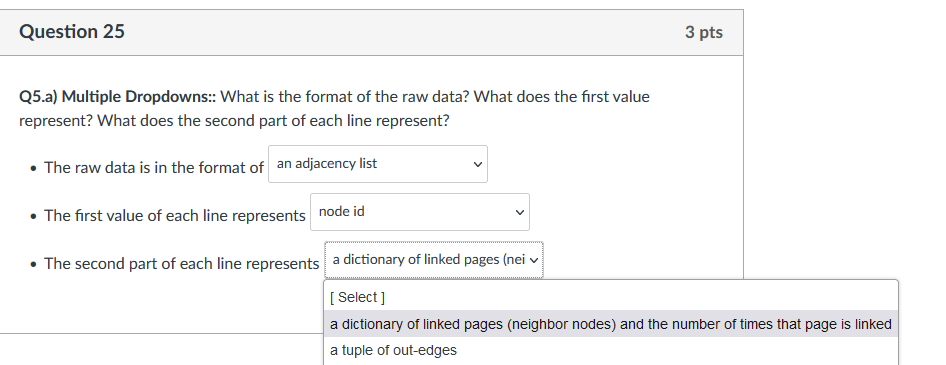

> __b)__ 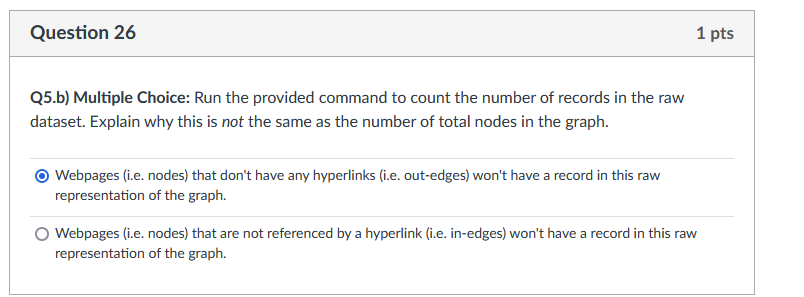

> **c)** 5,781,290

> __d)__ 9410987

In [ ]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

In [30]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    totalCount = None  # replace with your code
    import ast
    from operator import add
    def countMapper(x):
        node_id, edgedict = x.split('\t')
        edgedict = ast.literal_eval(edgedict)
        yield (node_id, 1)
        for k,v in edgedict.items():            
            yield (k,1)
    totalCount = dataRDD.flatMap(countMapper).foldByKey(0, add).count()
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [114]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.2505035400390625 seconds.
Total Nodes: 11


In [115]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

23/07/22 23:59:33 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=151; previousMaxLatencyMs=130; operationCount=9410; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/all-pages-indexed-out/part-00005.gz
23/07/22 23:59:33 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=176; previousMaxLatencyMs=151; operationCount=9447; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/all-pages-indexed-out/part-00003.gz
23/07/22 23:59:34 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=288; previousMaxLatencyMs=176; operationCount=9471; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/all-pages-indexed-out/part-00010.gz
23/07/22 23:59:34 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected

... completed job in 113.18377566337585 seconds.
Total Nodes: 15192277


In [12]:
15192277 - 5781290


9410987

# ✅ Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:

* __a1) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
  * Count the number of out-degree for each __non-dangling node__ and return the names of the top 10 pages with the most hyperlinks
  * Find the average out-degree for all __non-dangling nodes__ in the graph
  * Take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
<br>
<br>
 
* __a2) Numeric:__ What is the average out-degree of the `testRDD`?

* __a3) Multiple Choice:__ What is the top node by out-degree of the `wikiRDD`?

* __b) Multiple Dropdown:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) Multiple Answer:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others? Select all that apply. [__Hint:__ _select 3 answers_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> __a2)__ 2.2

> __a3)__ 7804599

> __b)__ 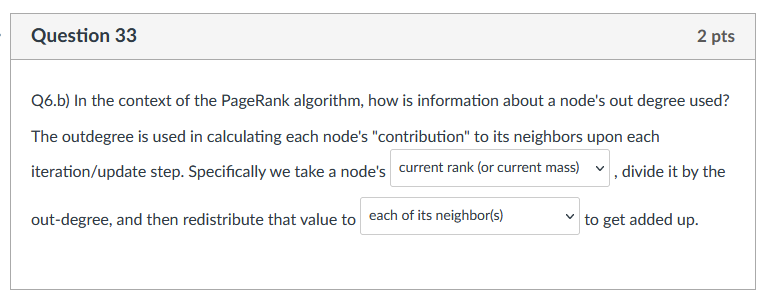

> __c)__ 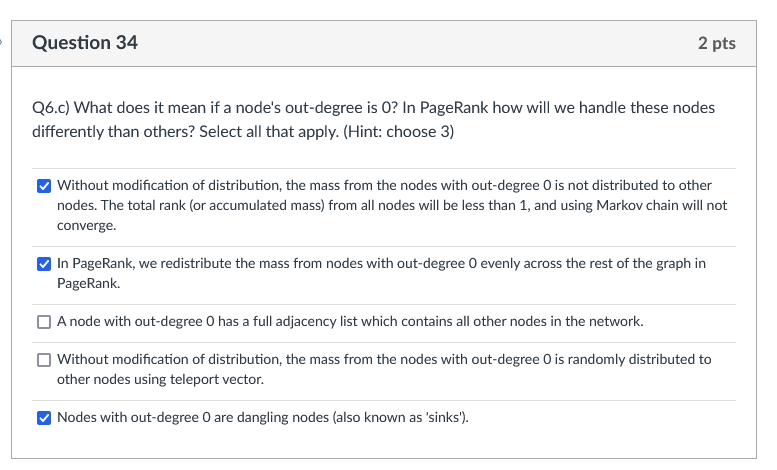

In [65]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    outDegrees = dataRDD.map(parse).map(lambda x: (x[0], sum( x[1].values() ) ) ).cache()
    top = outDegrees.takeOrdered(10, key=lambda x: -x[1])
    
    avgDegree = outDegrees.map(lambda x: x[1]).mean()
    sampledCounts = outDegrees.map(lambda x: x[1]).takeSample(False, n)
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [18]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 0.8121767044067383 seconds
Average out-degree:  2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('3', 2), ('4', 2), ('7', 2), ('8', 2), ('9', 2), ('11', 2), ('2', 1), ('10', 1)]


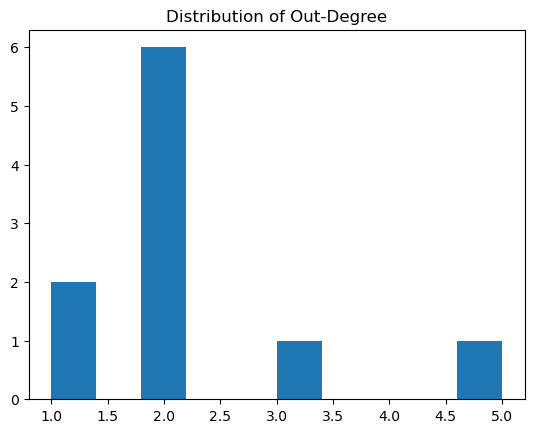

None

In [19]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [66]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 65.75642561912537 seconds
Average out-degree:  32.04181575392325
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904)]


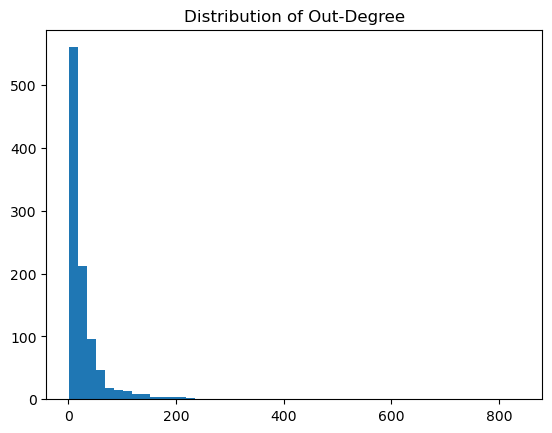

None

In [67]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# ✅ Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code $N$.

### Q7 Tasks:
* __a) Multiple Choice:__ What is $N$? 

* __b) Multiple Selection:__ Using the analogy of the infinite random web-surfer, how do we use $\frac{1}{N}$? [__HINT:__ _select 2 answers_]

* __c) True or False:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Select True or False for each of the statements.

* __d) Code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it edges (neighbors) to be a empty [__HINT:__ _you should use the same data type with the edges for non-dangling nodes_]
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __e) Numerical Answer:__ Run the provided code to confirm that your job in `part d` has a record for each node. Your records should match the format specified in the docstring and the count should match what you computed in question 5. Then answer the question: how many edges does the node `13415942` have? [__`TIP:`__ _you might want to take a moment to write out what expected outputs you should get for the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

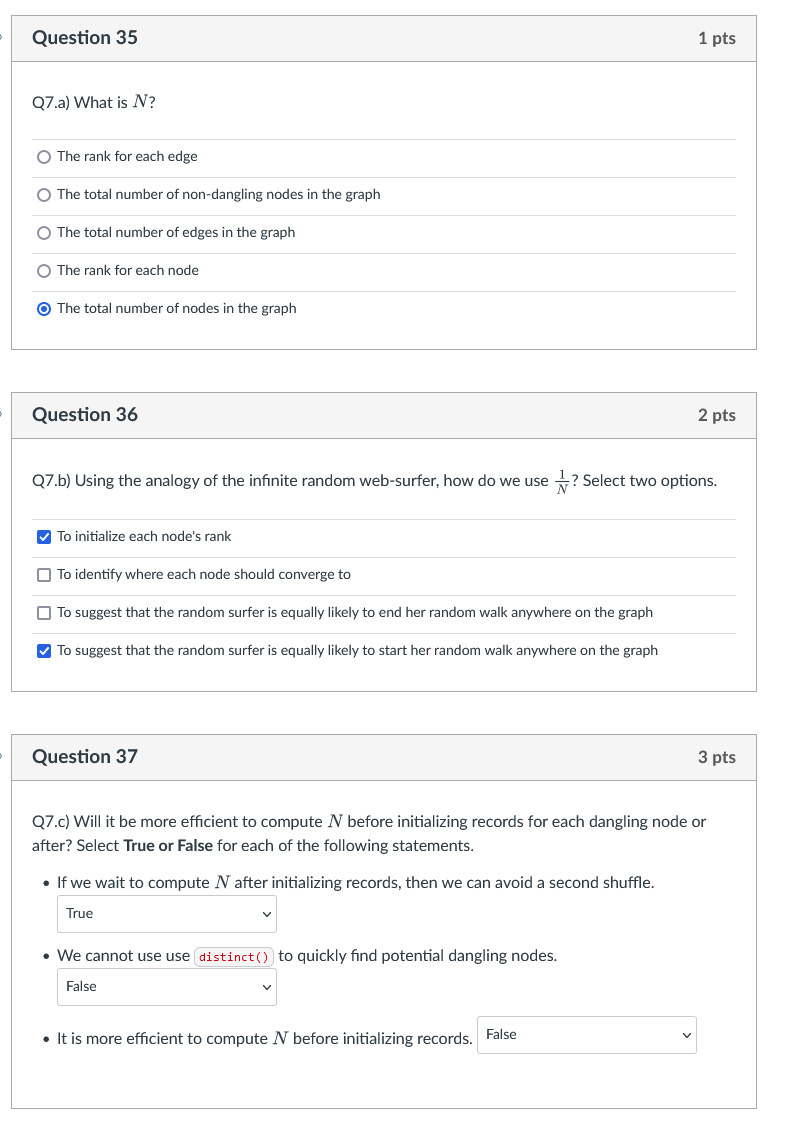

> __e)__ Type your answer here!

In [31]:
# part d - job to initialize the graph
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    def explode_dict(edges):
        r = [[k]*v for k,v in edges.items()]
        return ','.join([item for sublist in r for item in sublist])
    
    def parse(line):
        nodeid, edges = line.split('\t')
        edges = ast.literal_eval(edges)
        edgestr = explode_dict(edges)
        yield (nodeid, edgestr)
        # Yield one for each node in the edges, because we don't know if they're dangling yet (until we've seen all the nodes)
        for k,v in edges.items():
            yield (k, '')
    
    
    def combineDicts(e1, e2):
        if len(e1) == 0:
            return e2
        elif len(e2) == 0:
            return e1
        
    
    # write your main Spark code here
    g1 = dataRDD.flatMap(parse).reduceByKey(combineDicts).cache()
    N = g1.count()
    
    graphRDD = g1.map(lambda x: (int(x[0]), (1/N,  x[1])))
    
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [32]:
# part e - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.897676944732666 seconds.


[(4, (0.09090909090909091, '1,2')),
 (1, (0.09090909090909091, '')),
 (8, (0.09090909090909091, '2,5')),
 (9, (0.09090909090909091, '2,5')),
 (10, (0.09090909090909091, '5')),
 (2, (0.09090909090909091, '3')),
 (3, (0.09090909090909091, '2,2')),
 (5, (0.09090909090909091, '4,4,4,2,6')),
 (6, (0.09090909090909091, '2,5,5')),
 (7, (0.09090909090909091, '2,5')),
 (11, (0.09090909090909091, '5,5'))]

In [33]:
# part e - run your code on the main graph (RUN THIS CELL AS IS)
# Takes about 100 seconds
start = time.time()
wikiGraphRDD = initGraph(wikiRDD).cache()
print(f'... full graph initialized in {time.time() - start} seconds')

23/07/26 06:15:35 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=136; previousMaxLatencyMs=92; operationCount=9357; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/all-pages-indexed-out/part-00008.gz
23/07/26 06:15:35 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=142; previousMaxLatencyMs=136; operationCount=9390; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/all-pages-indexed-out/part-00011.gz
23/07/26 06:15:35 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=177; previousMaxLatencyMs=142; operationCount=9398; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/all-pages-indexed-out/part-00007.gz


... full graph initialized in 206.3399522304535 seconds


In [16]:
# part e - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
node = wikiGraphRDD.sortByKey().lookup(13415942) 
print("Node 13415942's initialized record:", node)
print(f"\n\nNode 13415942 has {len(node[0][1].split(','))} outlinks.")
print(f'Time to complete: {time.time() - start} seconds.')

Total number of records: 15192277


Node 13415942's initialized record: [(6.582291778908455e-08, '3504656,9775848,11373963,13852436,3379424,2091222,6677493,6677493,1058085,1053553,1053553,6857069,9003031,5537932,8969422,13432623,8886615,3144451,2716670,13915988,1477521,5685569,9378589,5833323,13812056,13443607,6369178,9308815,13838758,9363771,8481855,4962740,9391535,13506560,11933440,8048021,14003665,2091220,2091220,3094953,3094953,3094953,6167868,10232538,4962727,12254674,6085187,13853352,4763720,2396377,10918156,2722192,10131325,9704310,11544220,495535,9268175,3170806,3170806,9003037,9003037,3969908,14007066,13455888,14703794,14024536,1644036,5268185,11620493,12061491,12061491,9255564,6312586,3103819,1053549,6514419,4382835,13328060,2958561,9373697,3042177,14730511,7634942,2368552,14743233,4047561,12690702,7491066,8129926,13834510,13834510,984402,984402,12962553,12061480,3814267,6957969,5770648,5770648,13432242,13432242,6702970,11859764,10737734,10737734,8251474,1346778,13444906,8686851,3109476,13691556,3144465,1140654

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) Multiple Answers:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$. 
    [__Hint__: _select two answers_]

* __b) Multiple Choice:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) Numerical Answer:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) Code & Multiple Choice:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  <br>

  Then answer the question: What is the top ranked node of the `wikiaGraphRDD`?
    
> TIP: You can check your work for part `d` by looking at the nodes in the top 20-40th positions by PageRank score, which should match the expected output.

   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ 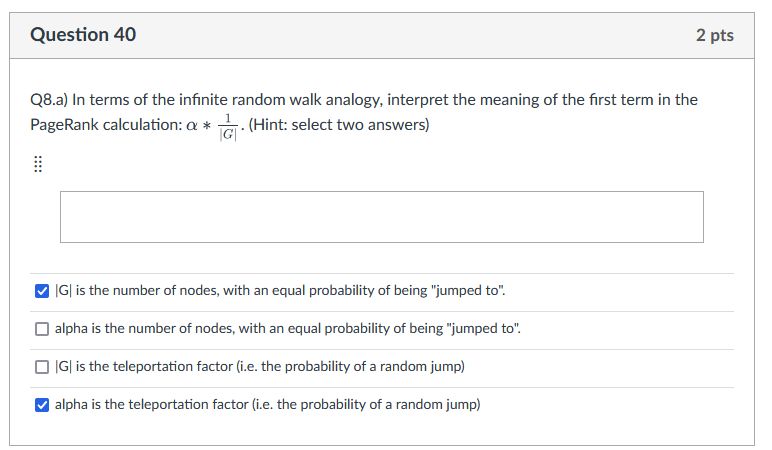

> __b)__ 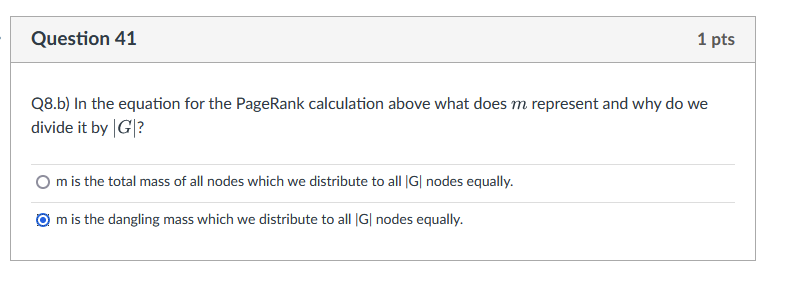

> __c)__ 1

The following cell can be used as additonal info / background knowledge on how to create a custom accumulator class. **YOU DO NOT NEED TO USE THIS CLASS IN ORDER TO COMPLETE THE ASSIGNMENT.**

In [34]:
#  *** OPTIONAL.. SEE NOTE ABOVE ***
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS) 

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We strongly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [35]:
# part d - job to run PageRank
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    N = sc.broadcast(graphInitRDD.count())
    
    def calc_dangling_mass(x):
        node_id, y = x
        rank, edgestr = y
        if len(edgestr) == 0:
            mmAccum.add(rank)

    def distribute_mass(x):
        node_id, y = x
        score, edgestr = y
        edges = edgestr.split(',') if len(edgestr) > 0 else []
        n = len(edges)
        new_score = (score / float(n)) if n != 0.0 else 0
        for e in edges:
            yield (int(e), (new_score, ''))
        # Yield the original node and its edges
        yield (node_id, (0.0, edgestr))
    
    def step2(x, y):
        ns1 = x[0]
        ns2 = y[0]
        # TODO: ignore the original list
        return (ns1 + ns2, x[1] + y[1])

    def calc_page_rank(x):
        node_id, y = x
        score, edges = y
        dangling_mass = dangm.value / N.value
        new_score = (a.value / N.value) + (d.value)*(dangling_mass + score)
        totAccum.add(new_score)
        return node_id, (new_score, edges)
    
    steadyStateRDD = graphInitRDD.cache()
    
    for i in range(maxIter):
        mmAccum.value = 0.0
        totAccum.value = 0.0

        # Get dangling mass
        steadyStateRDD.foreach(calc_dangling_mass)
        
        dangm = sc.broadcast(mmAccum.value)

        steadyStateRDD = steadyStateRDD.flatMap(distribute_mass)\
         .reduceByKey(step2)\
         .map(calc_page_rank).cache()
        
        if verbose:
            print(f'\nStep {i}:')
            for node, score in steadyStateRDD.collect():
                print(f'Node: {node}\tPageRank: {score}')
            print(dangm.value)

    steadyStateRDD = steadyStateRDD.map(lambda x: (x[0], x[1][0]))

    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [36]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 2.5997660160064697 seconds.
Top 20 ranked nodes:


[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (9, 0.01692511778009981),
 (7, 0.01692511778009981),
 (11, 0.01692511778009981)]

---
__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```
---

In [ ]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTES: 
# - wikiGraphRDD should have been computed & cached above!
# - Rounding errors after 10 or so decimal places are acceptable
# - This will take a long time to run...about 30 minutes on 16 cores
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'\n...trained {nIter} iterations in {time.time() - start} seconds.\n')

print(f'Top 20-40th ranked nodes:\n')
top_40 = full_results.takeOrdered(40, key=lambda x: - x[1])
# print results from 20th to 40th highest PageRank
for result in top_40[20:]:
    print(result)


...trained 10 iterations in 1540.6266803741455 seconds.

Top 20-40th ranked nodes:



(9386580, 0.00029569704195661563)
(15164193, 0.00028430185145654046)
(7576704, 0.00028070286946292865)
(12074312, 0.0002789390949918955)
(3191491, 0.0002733179890615316)
(2797855, 0.000272895494663879)
(11253108, 0.00027242406044634775)
(13725487, 0.0002702094553765271)
(2155467, 0.0002664929816794764)
(7835160, 0.00026125677808592134)
(4198751, 0.0002589299830753193)
(9276255, 0.0002546338645363723)
(10469541, 0.00025370147153616813)
(11147327, 0.0002515464509095224)
(5154210, 0.0002492702962065456)
(2396749, 0.00024811589129597055)
(3603527, 0.00024651367256572156)
(3069099, 0.00023478481004084875)
(12430985, 0.0002334928892642039)
(9355455, 0.0002265800469690849)


---
**Expected output for pages in top 20-40:**
```
(9386580, 0.0002956970419566159)
(15164193, 0.0002843018514565407)
(7576704, 0.00028070286946292773)
(12074312, 0.0002789390949918953)
(3191491, 0.0002733179890615315)
(2797855, 0.0002728954946638793)
(11253108, 0.000272424060446348)
(13725487, 0.00027020945537652716)
(2155467, 0.0002664929816794768)
(7835160, 0.00026125677808592145)
(4198751, 0.00025892998307531953)
(9276255, 0.0002546338645363715)
(10469541, 0.0002537014715361682)
(11147327, 0.00025154645090952246)
(5154210, 0.00024927029620654557)
(2396749, 0.0002481158912959703)
(3603527, 0.0002465136725657213)
(3069099, 0.00023478481004084842)
(12430985, 0.0002334928892642041)
(9355455, 0.00022658004696908508)
```
 ---

In [38]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

['! $var = &quot;&quot;\t1\t1\t0']

In [68]:
top_40[0]

(13455888, 0.0015447247129833387)

In [39]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [40]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

[(1, '! $var = &quot;&quot;'), (2, '! (CONFIG.SYS directive)')]

In [41]:
# part d - What is the top ranked node of the wikiaGraphRDD - (RUN THIS CELL AS IS)
top_40_RDD = sc.parallelize(top_40)
top_40_RDD.take(1)

[(13455888, 0.0015447247129833387)]

# Question 9 - Pretty Print

### Q9 Tasks
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and their IDs.

* __a) Code:__ Join this dataset with your top 40 results. The print statement provided will display the pages in the top 20-40th positions.

* __b) Fill in the blank:__ The title of the page associated with the PageRank score of 0.000279 is _____.

### Q9 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> __b)__ Type your answer here! 

Join with indexRDD and print pretty

In [44]:
# part a
############## YOUR CODE HERE ###############
joinedWithNames = top_40_RDD.join(namesKV_RDD).collect()   # replace with your code
############## END YOUR CODE ###############

23/07/26 06:59:10 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=185; previousMaxLatencyMs=177; operationCount=19428; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/indices/part-00006.gz
23/07/26 06:59:10 WARN com.google.cloud.hadoop.fs.gcs.GhfsStorageStatistics: Detected potential high latency for operation stream_read_operations. latencyMs=187; previousMaxLatencyMs=185; operationCount=19437; context=gs://w261-hr/notebooks/jupyter/Assignments/HW5/data/indices/part-00010.gz


In [47]:
joinedWithNames[:10]

[(7576704, (0.00028070286946292865, 'Lepidoptera')),
 (15164193, (0.00028430185145654046, 'village')),
 (5154210, (0.0002492702962065456, 'Gmina')),
 (4196067, (0.0004423778888372559, 'England')),
 (3191491, (0.0002733179890615316, 'Countries of the world')),
 (10469541, (0.00025370147153616813, 'Powiat')),
 (14112583, (0.0003943847283754832, 'World War II')),
 (3603527, (0.00024651367256572156, 'Departments of France')),
 (5051368, (0.0005983856809747844, 'Germany')),
 (12074312, (0.0002789390949918955, 'Spain'))]

In [54]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("Page ID","PageRank","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:10d}\t| {:10f}\t| {}".format(r[0],r[1][0],r[1][1]))

Page ID   	| PageRank  	| Title
   7576704	|   0.000281	| Lepidoptera
  15164193	|   0.000284	| village
   5154210	|   0.000249	| Gmina
   4196067	|   0.000442	| England
   3191491	|   0.000273	| Countries of the world
  10469541	|   0.000254	| Powiat
  14112583	|   0.000394	| World War II
   3603527	|   0.000247	| Departments of France
   5051368	|   0.000598	| Germany
  12074312	|   0.000279	| Spain
  13425865	|   0.000442	| United Kingdom
   6237129	|   0.000352	| Italy
  12430985	|   0.000233	| Sweden
   4695850	|   0.000671	| France
   7902219	|   0.000370	| List of sovereign states
   2155467	|   0.000266	| Brazil
   3069099	|   0.000235	| Communes of France
   2437837	|   0.000462	| Canada
   2396749	|   0.000248	| California
  13725487	|   0.000270	| Voivodeships of Poland
  13455888	|   0.001545	| United States
   6172466	|   0.000422	| Iran
   6113490	|   0.000396	| Insect
  12836211	|   0.000362	| The New York Times
   9386580	|   0.000296	| New York City
  11253108	|   0.00

# Question 10 - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API. If you're doing graph-based analysis in the future, this is a great tool that you can use. GraphFrames does calculations like PageRank is about 25% of the time that you can achieve using the map-reduce paradigm you've used up to this point. The goal of this final question is to expose you to this tool so that you at least have some knowledge of its basic functionality.

### Q10 Tasks
* __a) code + Multiple Choice:__ Load in the Les Misérables data. Which character has their only edge connected to MmeBurgon?
* __b) code + Multiple Choice:__ Complete the code to run the GraphFrames implementation of PageRank and report out the top 10 characters. Which character had the third highest PageRank value?

### Q10 Student Answers:
OPTIONAL - if you'd like to save your answers in this notebook: 

> __a)__ Type your answer here! 

> __b)__ Type your answer here! 

In [55]:
!pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.0 MB/s eta 0:00:00


In [56]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

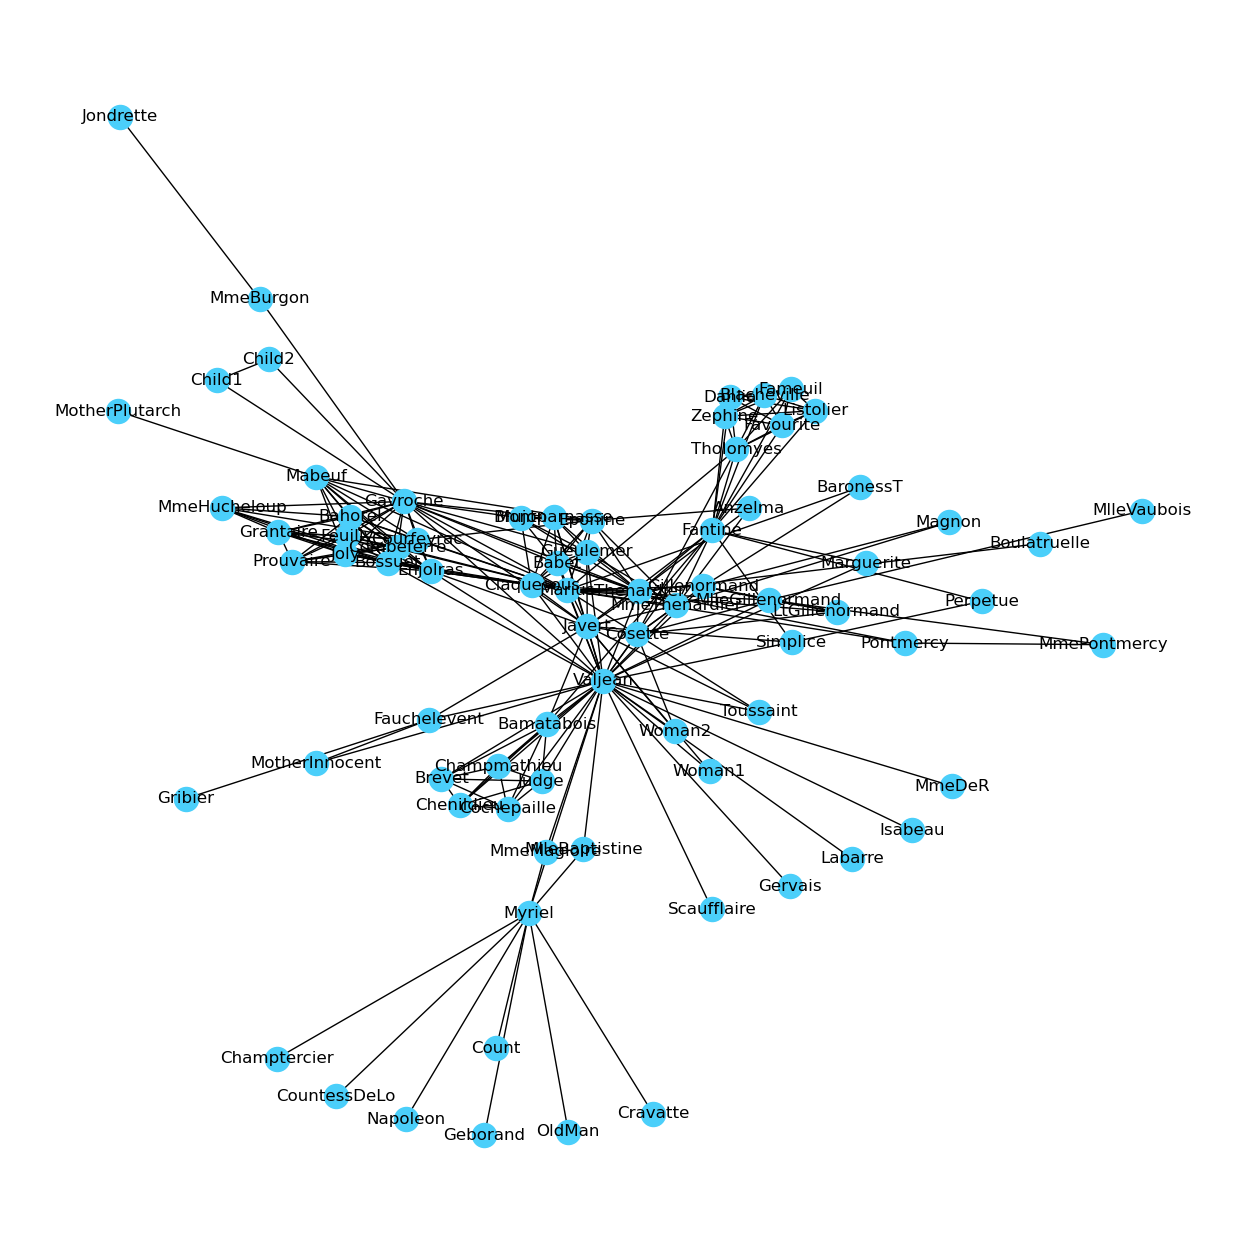

In [57]:
# part a - (RUN CELL AS IS)

# load in the les miserable network 
G = nx.les_miserables_graph()

# take a look at the graph (you can RUN CELL AS IS or feel free adjust the view)
fig, ax = plt.subplots(figsize=(16, 16)) 
nx.draw(G, with_labels=True, ax=ax, node_color='#4bcffa')

In [58]:
# creates the vertices and edges (RUN CELL AS IS)
vertices = spark.createDataFrame(list(G.nodes), StringType())
edges = spark.createDataFrame(list(G.edges))

vertices = vertices.select(vertices.value.alias('id')).distinct()

edges = edges.withColumnRenamed('_1','src')
edges = edges.withColumnRenamed('_2','dst')

In [59]:
# take a look at the vertices (RUN CELL AS IS)
vertices.show(10)

+--------------+
|            id|
+--------------+
|      Napoleon|
|       Isabeau|
|LtGillenormand|
|       Bahorel|
|        Woman1|
|MotherPlutarch|
|        MmeDeR|
|     Prouvaire|
|     Gueulemer|
|  MmeHucheloup|
+--------------+
only showing top 10 rows



In [60]:
# take a look at the edges (RUN CELL AS IS)
edges.show(10)

+--------+--------------+
|     src|           dst|
+--------+--------------+
|Napoleon|        Myriel|
|  Myriel|MlleBaptistine|
|  Myriel|   MmeMagloire|
|  Myriel|  CountessDeLo|
|  Myriel|      Geborand|
|  Myriel|  Champtercier|
|  Myriel|      Cravatte|
|  Myriel|         Count|
|  Myriel|        OldMan|
|  Myriel|       Valjean|
+--------+--------------+
only showing top 10 rows



In [61]:
# part b
# Create a GraphFrame
f = GraphFrame(vertices, edges)

# TODO: call the pageRank algorithm, with resetProbability=0.15 and maxIter=10
# Don't worry about the warnings
############## YOUR CODE HERE ###############
results = f.pageRank(resetProbability=0.15, maxIter=10)
############## END YOUR CODE ###############

23/07/26 07:09:47 WARN org.apache.spark.storage.BlockManager: Block rdd_317_45 already exists on this machine; not re-adding it
23/07/26 07:09:47 WARN org.apache.spark.storage.BlockManager: Block rdd_317_63 already exists on this machine; not re-adding it
23/07/26 07:09:47 WARN org.apache.spark.storage.BlockManager: Block rdd_317_83 already exists on this machine; not re-adding it
23/07/26 07:09:48 WARN org.apache.spark.storage.BlockManager: Block rdd_317_192 already exists on this machine; not re-adding it


In [62]:
# part b (continued)

# TODO: order the results in descending order and limit to the top 10 characters
start = time.time()
############## YOUR CODE HERE ###############
top_10 = results.vertices.orderBy(F.desc("pagerank")).limit(10)

############## END YOUR CODE ###############
print(f'... completed job in {time.time() - start} seconds.')

... completed job in 0.02403712272644043 seconds.


In [63]:
%%time
# part b (continued)
top_10.show()

+------------+------------------+
|          id|          pagerank|
+------------+------------------+
|MmeHucheloup| 5.019565265853954|
|     Fantine| 3.177318468809175|
|      Brujon|3.1578257780664503|
|   Grantaire|2.9068367945265403|
| Cochepaille| 2.742962468181058|
|        Joly| 2.220436772473558|
|      Marius|1.9314716784839994|
|    Simplice|1.7987337264693872|
|Montparnasse| 1.770629729161687|
|     Bossuet|1.7575083160751706|
+------------+------------------+

CPU times: user 30.6 ms, sys: 7.06 ms, total: 37.7 ms
Wall time: 1.67 s


### Congratulations, you have completed the last homework for 261! 